# Determining a prospective tariff for a telecom company

## Description of the project, tariffs and data

### Project description

*Customers are offered* two tariff plans: Smart and Ultra. To *adjust the advertising budget*, the commercial department wants to understand **which plan makes more money**. You will have to do a preliminary analysis of the tariffs on a small sample of customers. You have data from 500 Megaline users: who they are, where they're from, what tariff they use, how many calls and texts each sent in 2018. **You *need* to *analyse customer behaviour* and *determine which tariff is better*.

### Tariff description

1. **Smart tariff:**
    1. Monthly fee: 550 roubles
    2. Includes 500 minutes of talk time, 50 messages and 15GB of internet traffic
    3. *Cost of services beyond the tariff package: *. 
        1. minute of talk time: 3 rubles* ("Megaline" always rounds up the values of minutes and megabytes. *If the user only spoke for 1 second, the whole minute is counted in the tariff*);
        2. message: 3 roubles; 
        3. 1 Gb of Internet traffic: 200 RUB

2. **Ultra tariff:**
    1. Monthly fee: 1950 roubles
    2. 3000 minutes of talk time, 1000 messages and 30 GB of Internet traffic included
    3. *Cost of services over and above the tariff package:* 
        1. calling minute: 1. ruble; 
        2. message: 1 RUB; 
        3. 1 Gb of internet traffic: 150 RUB.

Important: Megaline always **rates seconds to minutes** and **megabytes to gigabytes**. 

1. Each **call is rounded separately**: even if it only lasted 1 second, it will count as 1 minute.

2. For web traffic, *individual sessions are not counted*. Instead, the total **amount for the month is rounded upwards**. If a subscriber uses 1025 megabytes this month, they will be charged for 2 gigabytes.

### Data description

#### Users:

1. **user_id** - unique user ID;
2. *first_name* - user name;
3. *last_name* - user name;
4. *age* - user age (years);
5. *reg_date* - tariff connection date (day, month, year);
6. *churn_date* - tariff termination date (if the value is missing, the tariff was still valid at the moment of data unloading);
7. *city* - user's city of residence
8. **tarif** - name of the tariff plan

#### Calls:

1. **id** - unique call number;
2. *call_date* - date of the call;
3. *duration* - duration of the call in minutes;
4. **user_id** - ID of the user who made the call;

#### Messages:

1. **id** - unique message number;
2. *message_date* - date of message;
3. **user_id** - identifier of the user who sent the message

#### Internet:

1. *id* - unique session number;
2. *mb_used* - amount of Internet traffic spent per session (in megabytes);
3. *session_date* - date of the Internet session;
4. **user_id** - user ID;

#### Tariffs:

1. **tariff_name** - name of the tariff;
2. *rub_monthly_fee* - monthly subscription fee in roubles;
3. *minutes_included* - number of minutes per month included in the subscription fee;
4. *messages_included* - number of messages per month included in the subscription fee;
5. 5. *mb_per_month_included* - amount of the internet traffic included in the subscription fee (in megabytes);
6. *rub_per_minute* - the cost per minute of the conversation above the tariff package (for example, if the tariff has 100 minutes of conversation per month, then 7. *rub_per_minute* will be charged from 101 minutes);
8. *rub_per_message* - cost of message sending in excess of tariff package;
9. *rub_per_gb* - the cost of an additional gigabyte of internet traffic in excess of the tariff package (1 gigabyte = 1024 megabytes);

**Preliminary conclusions:**

1. The **USERS**, **CALLS**, **MESSAGE** and **INTERNET** tables can be merged based on a unique common column **user_id**. It is possible that the values from the **id** column will also display a unique number for the subscriber and this can also be tried as an additional parameter to merge.
2. To merge the table from step 1 with the **TARIFFS** table, the values taken from the tariff_name column can be used. The common table also has a **tarif** column that contains similar information.

## Main project:

### Downloading libraries and browsing data

In [1]:
import numpy as np
import pandas as pd
import datetime 
from scipy import stats as st
import matplotlib.pyplot as plt
import calendar
import warnings
warnings.filterwarnings("ignore")

# Constant values megabite in 1 gigabite
MB2GB = 1024

In [2]:
# Get data
def get_info(df, name):
    print('\n', '*' * 20, '\n')
    print(f'General information for the table{name} \n')
    df.info()
    display(df.head(5)) 
    print(f'\n Number of NaN values for the table {name}: \n', df.isnull().sum())
    if name != 'user_com_info':
        print(f'\n Number of duplicates for the table {name}:   ', df.duplicated().sum())
    print(f'\n Column names for the table {name}:'       , df.columns)
    if name == 'users':
        print('Unique values in the column city'  , np.sort(df['city'].unique()), '\n')
        print('Unique values in the column tariff', df['tariff'].unique(), '\n')    
    print('\n', '*' * 20, '\n')

mPath = 'C:/Users/Churiulin/Desktop/Yandex/Projects/'
    
# Get data
df_users    = pd.read_csv(f'{mPath}users.csv'   , sep = ',')
df_calls    = pd.read_csv(f'{mPath}calls.csv'   , sep = ',')
df_messages = pd.read_csv(f'{mPath}messages.csv', sep = ',')
df_internet = pd.read_csv(f'{mPath}internet.csv', sep = ',')
df_tarrif   = pd.read_csv(f'{mPath}tariffs.csv' , sep = ',')

# Get common information about data
info_users    = get_info(df_users   , 'users'   )
info_calls    = get_info(df_calls   , 'calls'   )
info_message  = get_info(df_messages, 'messages')
info_internet = get_info(df_internet, 'internet')
info_tarrif   = get_info(df_tarrif  , 'tariffs' ) 



 ******************** 

General information for the tableusers 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



 Number of NaN values for the table users: 
 user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

 Number of duplicates for the table users:    0

 Column names for the table users: Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')
Unique values in the column city ['Архангельск' 'Астрахань' 'Балашиха' 'Барнаул' 'Белгород' 'Брянск'
 'Владивосток' 'Владикавказ' 'Владимир' 'Волгоград' 'Волжский' 'Вологда'
 'Воронеж' 'Грозный' 'Екатеринбург' 'Иваново' 'Ижевск' 'Иркутск' 'Казань'
 'Калининград' 'Калуга' 'Кемерово' 'Киров' 'Кострома' 'Краснодар'
 'Красноярск' 'Курган' 'Курск' 'Липецк' 'Магнитогорск' 'Махачкала'
 'Москва' 'Мурманск' 'Набережные Челны' 'Нижневартовск' 'Нижний Новгород'
 'Нижний Тагил' 'Новокузнецк' 'Новороссийск' 'Новосибирск' 'Омск'
 'Оренбург' 'Орёл' 'Пенза' 'Пермь' 'Петрозаводск' 'Подольск'
 'Ро

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



 Number of NaN values for the table calls: 
 id           0
call_date    0
duration     0
user_id      0
dtype: int64

 Number of duplicates for the table calls:    0

 Column names for the table calls: Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

 ******************** 


 ******************** 

General information for the tablemessages 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



 Number of NaN values for the table messages: 
 id              0
message_date    0
user_id         0
dtype: int64

 Number of duplicates for the table messages:    0

 Column names for the table messages: Index(['id', 'message_date', 'user_id'], dtype='object')

 ******************** 


 ******************** 

General information for the tableinternet 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



 Number of NaN values for the table internet: 
 Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

 Number of duplicates for the table internet:    0

 Column names for the table internet: Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

 ******************** 


 ******************** 

General information for the tabletariffs 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name       

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



 Number of NaN values for the table tariffs: 
 messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

 Number of duplicates for the table tariffs:    0

 Column names for the table tariffs: Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

 ******************** 



**Preliminary conclusions:**

1. The data have been successfully obtained:
    1. We have a total of 500 subscribers, with 38 of them having their contract with Megalight terminated at the time the data was received. (Data from users table). 
    2. The calls and massege table shows 202607 and 123036 calls and sms cases each. Customers are more likely to use the rate for calls, while sms are used almost half as often. Probably some of the text messages are taken over by messengers for which the internet is used.
    3. The internet table shows 149396 occasions when people access the internet. People go on the internet more often than they text. 
    4. As expected, only two tariffs are presented in the table.

2. Change format of the **churn_date** and **reg_date** columns to datetime

3. Change format of the **call_date** column

4. Round up the values in the **duration** column and change the type to **int**. Also, the data description says that the duration of the call is specified in a minute then the duration cannot be, for example, 13.84 because there are only 60 seconds. But if we assume that 0.84 is a fraction of 60 seconds, then we have to split this number into two parts to get the exact call time: 13 и 0.84. Then 13 would represent the number of whole minutes, and the remainder multiplied by 60 would represent the number of seconds. But in this case, as the operator counts any number of seconds other than 0 for a minute, we can safely round up to the higher number, e.g. 13.84 to 14 minutes.

5. Change format of the **message_date** column

6. Delete column **Unnamed: 0**.

7. In the **mb_used** column you should: divide by 1024, thus getting the number of gigabytes for each user in one session, then you should calculate the total value for each user.

8. change the format in the **session_date** column

### Data pre-processing 

In [3]:
def change_format(data):
    return pd.to_datetime(data, format='%Y-%m-%d')

# Change format in users table
df_users['churn_date'] = change_format(df_users['churn_date'])
df_users['reg_date']   = change_format(df_users['reg_date'])

# Change format in calls table
df_calls['call_date']  = change_format(df_calls['call_date'])
df_calls['duration']   = np.ceil(df_calls['duration']).astype('int64')


# Change format in messages table
df_messages['message_date'] = change_format(df_messages['message_date'])

# Change format in internet table
df_internet = df_internet.drop(['Unnamed: 0'], axis = 1)
df_internet['session_date'] = change_format(df_internet['session_date'])
df_internet['mb_used']      = np.ceil(df_internet['mb_used']).astype('int64')

### Search for gross errors

In addition, our data may contain gross errors. Let's take a closer look at our data, in particular we are interested in the following data columns:
1. table users - column **age**;
2. calls table - column **duration**; And check the maximum and minimum date from the **call_date** column
3. table messages - column **message_date**; And check the maximum and minimum date. Whether it is adequate.
4. table internet - column **mb_used**, and date	


In [4]:
def histogram(df, col, bin):
    df.plot(y = col      , title = col,
            kind = 'hist', bins  = bin,
            grid = True  )

def boxplots(df, col):
    df.plot(y = col     , title = col, 
            kind = 'box', grid = True)  

Descriptive statistics: 
 count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64


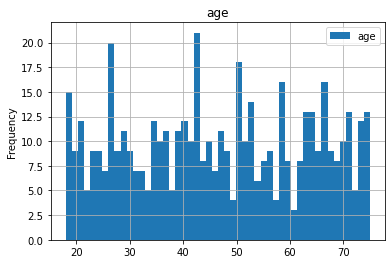

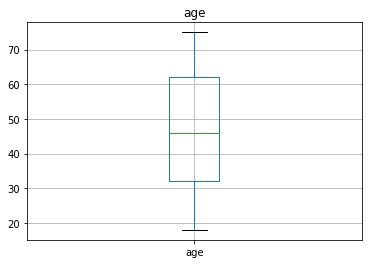

In [6]:
plot1 = histogram(df_users, 'age', 50)
plot2 = boxplots(df_users, 'age')
stat = df_users['age'].describe()
print(f'Descriptive statistics: \n', stat)

Descriptive statistics: 
 count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64


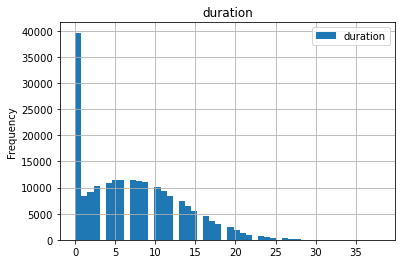

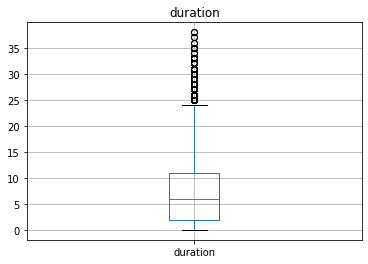

In [7]:
plot1 = histogram(df_calls, 'duration', 50)
plot2 = boxplots(df_calls, 'duration')
stat = df_calls['duration'].describe()
print(f'Descriptive statistics: \n', stat)

The **duration** column clearly identifies calls with 0 duration, but by the terms of the assignment such data is not an error, but missed calls. In turn, calls with duration more than 25 will not be an error either, just that someone likes to talk for a long time.

In [8]:
stat = df_calls['call_date'].describe()
print(f'Descriptive statistics: \n', stat)

Descriptive statistics: 
 count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object


The calls have been going on for one year, and in principle they are fine here too

In [9]:
stat = df_messages['message_date'].describe()
print(f'Descriptive statistics: \n', stat)

Descriptive statistics: 
 count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object


The SMS have been sent for one year, in principle all is well here too.

Descriptive statistics: 
 count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64


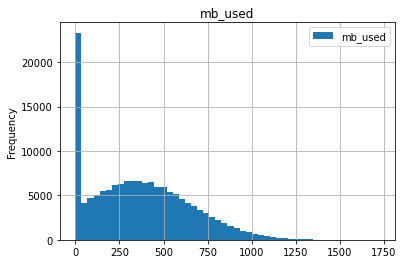

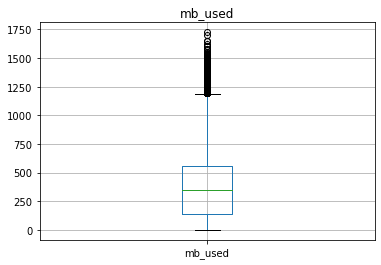

In [10]:
plot1 = histogram(df_internet, 'mb_used', 50)
plot2 = boxplots(df_internet, 'mb_used')
stat = df_internet['mb_used'].describe()
print(f'Descriptive statistics: \n', stat)

There are zero values in the internet traffic table, in principle since we need to calculate the total traffic per month, such values are of little value and can be discarded

In [10]:
df_internet = df_internet.query('mb_used != 0')

Descriptive statistics: 
 count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64


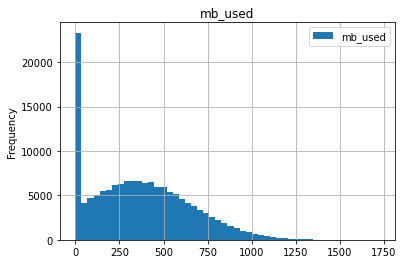

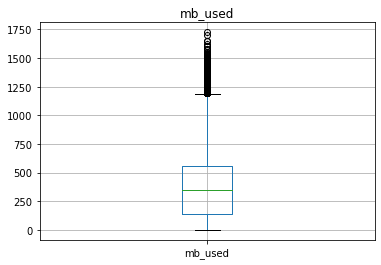

In [11]:
plot1 = histogram(df_internet, 'mb_used', 50)
plot2 = boxplots(df_internet, 'mb_used')
stat = df_internet['mb_used'].describe()
print(f'Descriptive statistics: \n', stat)

It is worth noting that most of our users use between 250 and 500 mb of internet traffic at a time. Special users sometimes use 1500 mb or more at once.

In [12]:
stat = df_internet['session_date'].describe()
print(f'Descriptive statistics: \n', stat)

Descriptive statistics: 
 count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object


**Preliminary conclusions:**

A review of the original data has been carried out, gross errors eliminated, and data formats corrected where necessary.

## Compiling data and finding first answers

Based on the available data I will create three common tables, one table will contain users and calls, the second users and sms, the third users and internet traffic.

In [13]:
#--------------------------------------
# input parameters: df_base - датафрейм на основе, которого будем объединять
#                   df_add  - датафрейм, который будем добавлять к df_base
#                   column  - параметр на основе, которого будем объединять
#--------------------------------------
def df_merge(df_base, df_add, column):
    df_new = df_base.merge(df_add, on = column, how = 'outer')
    return df_new

# Merge users and calls    
df_users_call     = df_merge(df_users, df_calls, 'user_id')

# Merge user and message
df_users_message  = df_merge(df_users, df_messages, 'user_id')

# Merge user and internet
df_users_internet = df_merge(df_users, df_internet, 'user_id')

In [14]:
#--------------------------------------
# input parameters: df  - input column
#                   col - column with actual data
#--------------------------------------
def add_data(df, col):
    df['year']  = pd.DatetimeIndex(df[col]).year
    df['month'] = pd.DatetimeIndex(df[col]).month
    df['day']   = pd.DatetimeIndex(df[col]).day
    return df
    
# Add columns with year, month, day    
df_users_call     = add_data(df_users_call    , 'call_date'   )
df_users_message  = add_data(df_users_message , 'message_date')
df_users_internet = add_data(df_users_internet, 'session_date')    
    

In [15]:
df_users_call

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,year,month,day
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0,2018.0,7.0,25.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0,2018.0,8.0,17.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0,2018.0,6.0,11.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0,2018.0,9.0,21.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0,2018.0,12.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202610,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1499_215,2018-12-26,1.0,2018.0,12.0,26.0
202611,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1499_216,2018-10-18,19.0,2018.0,10.0,18.0
202612,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1499_217,2018-11-10,11.0,2018.0,11.0,10.0
202613,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,1499_218,2018-10-06,5.0,2018.0,10.0,6.0


Create dataframes grouped by month for calls, messages and internet traffic, and subscriber rates

In [16]:
# Call by user
user_call    = df_users_call.groupby(['user_id','month']).agg({'duration':['count','sum']})

# Message by user
user_message = df_users_message.groupby(['user_id','month']).agg({'id':['count']})

# Trafic by user
user_trafic  = df_users_internet.groupby(['user_id','month']).agg({'mb_used':['mean','sum']})

# Users tarrif
user_tarrif = df_users_internet.groupby(['user_id','month']).agg({'tariff':['unique']})

Create a common dataframe based on previously collected data

In [17]:
user_com_info = pd.concat([user_call    , 
                           user_message , 
                           user_trafic  , 
                           user_tarrif  ], axis = 1)
# rename columns
user_com_info.columns = ['call_count' , 'call_time'   , 
                         'messages'   , 'mb_used_mean', 
                         'mb_used_sum', 'tariff_name' ]

In [18]:
user_com_info = user_com_info.replace('ultra', 'ULTRA')
user_com_info = user_com_info.replace('smart', 'SMART')
user_com_info

call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1000    5.0          22.0      159.0      22.0    451.200000       2256.0   
        6.0          43.0      172.0      60.0    474.632653      23257.0   
        7.0          47.0      340.0      75.0    483.310345      14016.0   
        8.0          52.0      408.0      81.0    485.172414      14070.0   
        9.0          58.0      466.0      57.0    540.037037      14581.0   
...                   ...        ...       ...           ...          ...   
1498    10.0         41.0      247.0      42.0    349.220339      20604.0   
1499    9.0           9.0       70.0      11.0    369.600000       1848.0   
        10.0         68.0      449.0      48.0    307.051724      17809.0   
        11.0         74.0      612.0      59.0    367.020408      17984.0   
        12.0         69.0      492.0      66.0    290.600000      13077.0   

              tariff_name  
user_id month              
1000    5.0         ULTRA  
        6.0         ULTRA  
        7.0         ULTRA  
        8.0         ULTRA  
        9.0         ULTRA  
...                   ...  
1498    10.0        SMART  
1499    9.0         SMART  
        10.0        SMART  
        11.0        SMART  
        12.0        SMART  

[3214 rows x 6 columns]

Создам функцию для визуализации информации о каждом конкретном пользователе, например с ID = 1000

In [27]:
# Function for data vizualization
# Input data: df - datafreme with merge data
#             user_id - index of users
#             sms - column name for sms
#             calls - column name for calls
#             megabytes - column name for used megabyte 

def vis_user_activiti(df, user_id, sms, calls, megabytes, 
                      plot_users = True, llimit = False ):
    # Get info about user
    if plot_users == True:
        act_user  = df.loc[user_id]                             # get user_id
        user      = act_user.loc[:, [sms, calls, megabytes]]    # get columns for users
        
        # Define limits for y axis
        y_min  = 0
        y_max  = 501
        y_step = 100
        
    else:
        user      = df.loc[:, [sms, calls, megabytes]]
        
              
    # Start visualization

    # Get month labels for our user
    month_labels = []
    for mon in user.index:
        month_labels.append(calendar.month_name[int(mon)])

    # Get visualizatiom    
    fig, ax = plt.subplots(figsize = (14, 6))
    ax1     = ax.twinx()
    ax2     = ax.twinx()

    # Plot data
    #user.plot(kind = 'bar', ax = ax1, secondary_y='mb_used_sum')
    user.plot(kind = 'bar', ax = ax1, secondary_y = megabytes)
    
    # Set labels for x axis
    x_values = np.arange(0, len(month_labels) + 1, 1)
    plt.xticks(x_values, month_labels)
    
    # Set plot title
    if plot_users == True:
        ax.set_title(f'График активности абонента с user id: {user_id}',
                     fontsize = 14, pad = 20                           )
        # Set y label
        ax.set_ylabel('Суммарное количество минут и смс от абонента'   ,
                      color = 'black', fontsize = 14, labelpad = 20)
        
        # Set y label for second axis
        ax2.set_ylabel('Использовано трафика, мб'   ,
                        color = 'black', fontsize = 14, labelpad = 50)
    
    else:
        if llimit == False:
            ax.set_title(f'График активности абонентов за 2018 год',
                         fontsize = 14, pad = 20)     
            # Define limits for y axis
            y_min  = 0
            y_max  = 5000
            y_step = 500

        else:
            ax.set_title(f'График активности абонентов за 2018 год превышающие пакетные опции',
                         fontsize = 14, pad = 20) 
            # Define limits for y axis
            y_min  = 0
            y_max  = 20000
            y_step = 2500
            
        # Set y label for second axis
        ax2.set_ylabel('Использовано трафика, гб'   ,
                        color = 'black', fontsize = 14, labelpad = 50)            
        
        # Set y label
        ax.set_ylabel('Суммарное количество звонков и смс от абонентов',
                      color = 'black', fontsize = 14, labelpad = 20)            



    
    ax.set_yticks(np.arange(y_min, y_max, y_step))
    
    ax1.set_yticks([])
    ax2.set_yticks([])



    # Additional settings parameters for x axis
    for label in ax.xaxis.get_ticklabels():
        label.set_color('black')
        label.set_rotation(15)
        label.set_fontsize(12)

    # Additional settings parameters for y axis    
    for label in ax.yaxis.get_ticklabels():
        label.set_color('black')
        label.set_fontsize(14)

    # Settings parameteres for grid
    ax.grid(True , which     = 'major', 
                   color     = 'k'    , 
                   linestyle = 'solid',
                   alpha     = 0.5    )


    ax.autoscale(tight=True)

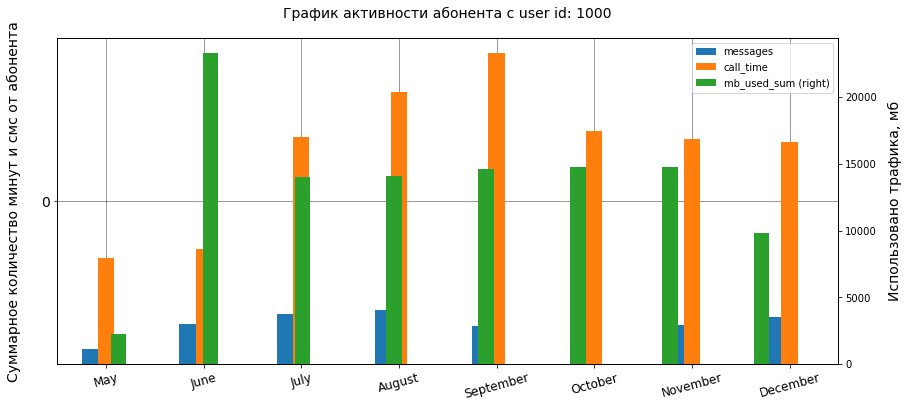

In [29]:
# Get user ID
ID = [1000]

for id_index in ID:
    plot4user = vis_user_activiti(user_com_info, id_index, 'messages', 'call_time', 'mb_used_sum')

### Analysis of nan values:

Теперь, когда у нас есть инструмент  для визуализции данных для каждого пользователя, посчитаем помесячную выручку с каждого пользователя по месяцам. Но прежде, чем рассчитать выручку еще раз проверим данные на наличие пропусков

In [30]:
print(get_info(user_com_info, 'user_com_info'))


 ******************** 

General information for the tableuser_com_info 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5.0) to (1499, 12.0)
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   call_count    3174 non-null   float64
 1   call_time     3174 non-null   float64
 2   messages      2717 non-null   float64
 3   mb_used_mean  3203 non-null   float64
 4   mb_used_sum   3203 non-null   float64
 5   tariff_name   3203 non-null   object 
dtypes: float64(5), object(1)
memory usage: 184.2+ KB


call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1000    5.0          22.0      159.0      22.0    451.200000       2256.0   
        6.0          43.0      172.0      60.0    474.632653      23257.0   
        7.0          47.0      340.0      75.0    483.310345      14016.0   
        8.0          52.0      408.0      81.0    485.172414      14070.0   
        9.0          58.0      466.0      57.0    540.037037      14581.0   

              tariff_name  
user_id month              
1000    5.0         ULTRA  
        6.0         ULTRA  
        7.0         ULTRA  
        8.0         ULTRA  
        9.0         ULTRA


 Number of NaN values for the table user_com_info: 
 call_count       40
call_time        40
messages        497
mb_used_mean     11
mb_used_sum      11
tariff_name      11
dtype: int64

 Column names for the table user_com_info: Index(['call_count', 'call_time', 'messages', 'mb_used_mean', 'mb_used_sum',
       'tariff_name'],
      dtype='object')

 ******************** 

None


**Preliminary conclusions:**

There are nan values in the data, we need to find out why we have omissions.

**Assumptions:**

Let's check if we have lost data by merging different dataframes into a common one. In case initially dataframes **df_users**, **df_calls**, **df_messages** and **df_internet**. Data was missing, then several options can be offered to fill in the gaps.
1. **Option 1.** The subscriber simply did not use this type of communication, so it is logical to assume that there would be omissions in this column. Replace them with 0. But first you should check if this is really the case.
2. **Option 2.** An error has been made in merging the data, causing the gaps to appear
3. **Option 3.** In case the values are missing from the **tariff_name** column, you need to analyse the data in more detail and see what this might be about.

Create a tool for detailed analysis of nan values

In [31]:
# Find lines with nan values
def nan_testing(df, col):
    print(f'Пропуски в колонке {col} \n ')
    nan_df = df.loc[df[col].isna()]
    return nan_df

# Get more detailed information about NaN values
def get_problems(df_test, df_user, df_data, lcalls = False, lmessage = False, ltrafic = False):
    problem_user = []
    problem_data = []
    
    # Get unique index
    calls_id   = df_test.index.get_level_values('user_id').unique()
    
    # Get problem places
    for id_user in calls_id:
        problem_user.append(df_user.loc[df_user['user_id'] == id_user])
        problem_data.append(df_data.loc[df_data['user_id'] == id_user])
    
    # Use this condition to save reseurses
    if lcalls == True:
        plot4user = vis_user_activiti(user_com_info, 1373, 'messages', 'call_time', 'mb_used_sum') 
    elif lmessage == True:
        plot4user = vis_user_activiti(user_com_info, 1036, 'messages', 'call_time', 'mb_used_sum')
    elif ltrafic == True:
        plot4user = vis_user_activiti(user_com_info, 1094, 'messages', 'call_time', 'mb_used_sum')
    else:
        for id_user in calls_id:
            plot4user = vis_user_activiti(user_com_info, id_user, 'messages'   , 
                                                                  'call_time'  ,
                                                                  'mb_used_sum')
    
    # Create problems dataframes
    df_problem_user = pd.concat(problem_user, axis = 0)
    df_problem_data = pd.concat(problem_data, axis = 0)    
    
    return df_problem_user, df_problem_data

#### Analysis of nan values in call data

Пропуски в колонке call_count 
 
Фамилии абонентов со странными звонками


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
91,1091,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
106,1106,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra
231,1231,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra
328,1328,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
373,1373,34,NaT,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart
473,1473,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra
476,1476,50,NaT,Москва,Валентина,Семенова,2018-04-30,ultra
489,1489,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


Оригинальные данные по звонкам


,id,call_date,duration,user_id
146542,1373_0,2018-09-19,9,1373
146543,1373_1,2018-05-23,8,1373
146544,1373_2,2018-02-11,2,1373
146545,1373_3,2018-09-30,0,1373
146546,1373_4,2018-05-03,5,1373
146547,1373_5,2018-10-17,0,1373
146548,1373_6,2018-10-21,0,1373
146549,1373_7,2018-04-19,0,1373
146550,1373_8,2018-10-10,3,1373
146551,1373_9,2018-01-24,0,1373


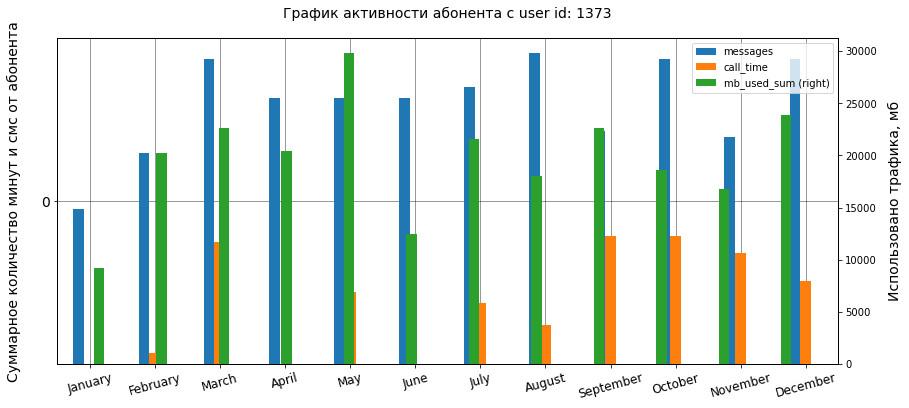

In [32]:
# Start testing
test_calls = nan_testing(user_com_info, 'call_count')

# Get data
problem_user, problem_call = get_problems(test_calls, df_users, df_calls, lcalls = True)

print('Фамилии абонентов со странными звонками')
display(problem_user)

print('Оригинальные данные по звонкам')
display(problem_call.head(10))

**Preliminary conclusions:**

Analysis of call skip patterns showed that the assumption was that the person in a particular month simply did not use the phone to make calls. The rest of the data is fine, as the graphs clearly show. The omissions in columns **call_count**, **call_time** are the same, so I will not check the second field additionally. 

#### Analysis of nan values in messeges

Пропуски в колонке messages 
 
Фамилии абонентов со странными смс


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
10,1010,26,NaT,Тюмень,Эдуард,Кононов,2018-08-05,smart
17,1017,73,NaT,Краснодар,Мария,Аленникова,2018-05-22,smart
24,1024,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra
...,...,...,...,...,...,...,...,...
466,1466,37,NaT,Новосибирск,Рубен,Шевцов,2018-02-28,ultra
469,1469,41,NaT,Сочи,Аксён,Абалкин,2018-07-06,ultra
476,1476,50,NaT,Москва,Валентина,Семенова,2018-04-30,ultra
479,1479,40,NaT,Хабаровск,Игорь,Богданов,2018-07-03,smart


Оригинальные данные по смс


,id,message_date,user_id
9242,1036_0,2018-10-17,1036
9243,1036_1,2018-09-06,1036
9244,1036_2,2018-08-12,1036
9245,1036_3,2018-09-28,1036
9246,1036_4,2018-10-02,1036
9247,1036_5,2018-10-12,1036
9248,1036_6,2018-08-04,1036
9249,1036_7,2018-08-29,1036
9250,1036_8,2018-09-03,1036
9251,1036_9,2018-09-05,1036


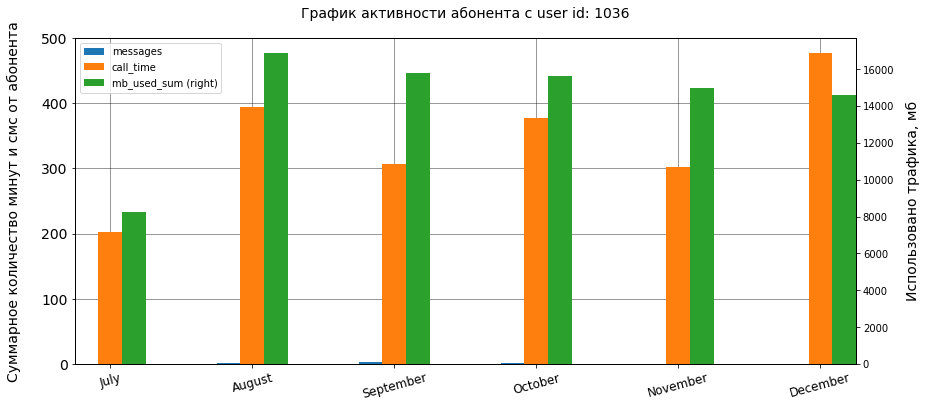

In [24]:
# Start testing
test_messages = nan_testing(user_com_info, 'messages')

# Get data
problem_user, problem_messages = get_problems(test_messages, df_users, df_messages, lmessage = True)

print('Фамилии абонентов со странными смс')
display(problem_user)

print('Оригинальные данные по смс')
display(problem_messages.head(10))

**Preliminary conclusions:**

The analysis of texting omissions showed that the assumption that a person simply did not use the phone for texting in one month or another was correct. Moreover, analysis of the data shows that such users have a higher prevalence of internet traffic than calls and explicit texting. Therefore I will assume that such subscribers use Internet messengers to communicate. The subscriber with user_id 1036 demonstrates this assumption well

#### Analysis of nan values in internet traffic

Пропуски в колонке mb_used_sum 
 
Фамилии абонентов со странным трафиком


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
94,1094,37,NaT,Новосибирск,Даниэла,Пугачева,2018-05-28,ultra
273,1273,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra
365,1365,38,NaT,Ростов-на-Дону,Георгий,Вишняков,2018-10-31,smart
377,1377,59,NaT,Брянск,Альфред,Семин,2018-02-25,ultra
392,1392,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra
446,1446,64,NaT,Липецк,Антонина,Артемчук,2018-08-31,smart


Оригинальные данные по интернет трафику


,id,mb_used,session_date,user_id
27138,1094_0,466,2018-08-07,1094
27139,1094_1,418,2018-07-10,1094
27140,1094_2,313,2018-06-07,1094
27141,1094_3,613,2018-12-23,1094
27142,1094_4,788,2018-09-29,1094
27143,1094_5,581,2018-09-19,1094
27144,1094_6,543,2018-06-18,1094
27145,1094_7,595,2018-07-03,1094
27146,1094_8,915,2018-09-29,1094
27147,1094_9,424,2018-09-30,1094


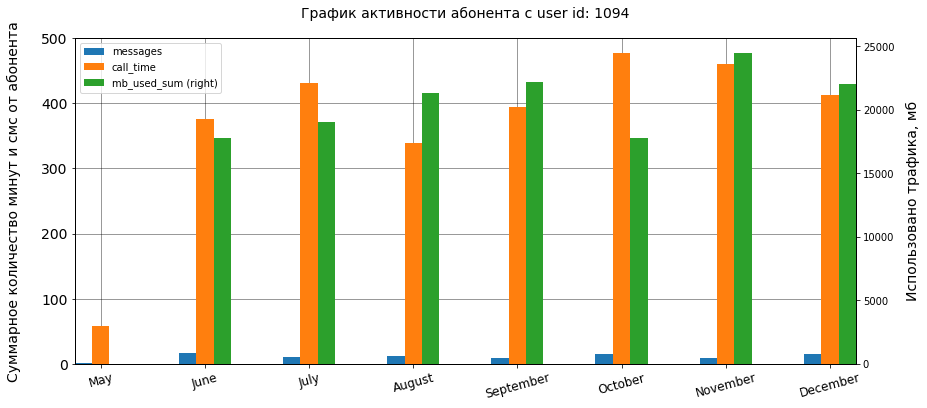

In [25]:
# Start testing
test_trafic = nan_testing(user_com_info, 'mb_used_sum')

# Get data
problem_user, problem_trafic = get_problems(test_trafic, df_users, df_internet, ltrafic = True)

print('Фамилии абонентов со странным трафиком')
display(problem_user)

print('Оригинальные данные по интернет трафику')
display(problem_trafic.head(10))

**Preliminary conclusions:**

Analysis of Internet traffic omissions showed that the assumption that a person simply did not use the phone for the Internet in one month or another was correct.

Replacing nan values in the columns

In [26]:
col_list = ['call_count', 'call_time', 'messages', 'mb_used_sum', 'mb_used_mean']

for col in col_list:
    user_com_info[col] = user_com_info[col].replace(np.nan, 0)

In [27]:
print(get_info(user_com_info  , 'user_com_info' )) 


 ******************** 

Общая информация для таблицы user_com_info 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5.0) to (1499, 12.0)
Data columns (total 6 columns):
call_count      3214 non-null float64
call_time       3214 non-null float64
messages        3214 non-null float64
mb_used_mean    3214 non-null float64
mb_used_sum     3214 non-null float64
tariff_name     3201 non-null object
dtypes: float64(5), object(1)
memory usage: 184.2+ KB


call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1000    5.0          22.0      159.0      22.0    564.000000       2256.0   
        6.0          43.0      172.0      60.0    528.568182      23257.0   
        7.0          47.0      340.0      75.0    500.571429      14016.0   
        8.0          52.0      408.0      81.0    521.111111      14070.0   
        9.0          58.0      466.0      57.0    583.240000      14581.0   

              tariff_name  
user_id month              
1000    5.0         ULTRA  
        6.0         ULTRA  
        7.0         ULTRA  
        8.0         ULTRA  
        9.0         ULTRA


 Количество NaN values для таблицы user_com_info: 
 call_count       0
call_time        0
messages         0
mb_used_mean     0
mb_used_sum      0
tariff_name     13
dtype: int64

 Названия столбцов для таблицы user_com_info: Index(['call_count', 'call_time', 'messages', 'mb_used_mean', 'mb_used_sum',
       'tariff_name'],
      dtype='object')

 ******************** 

None


With the skips in the call, text and internet traffic columns taken care of, we now need to find out why there are skips in the tariff information

#### Analysis of nan values in tariff 

Пропуски в колонке tariff_name 
 


call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1094    5.0          16.0      107.0       3.0           0.0          0.0   
1273    5.0          24.0      220.0      21.0           0.0          0.0   
        6.0          40.0      230.0      38.0           0.0          0.0   
        7.0          44.0      253.0      37.0           0.0          0.0   
        8.0          53.0      253.0      41.0           0.0          0.0   
        9.0          33.0      223.0      32.0           0.0          0.0   
        10.0         40.0      315.0      35.0           0.0          0.0   
        11.0         45.0      272.0      29.0           0.0          0.0   
        12.0         41.0      260.0      39.0           0.0          0.0   
1365    10.0          5.0       43.0       1.0           0.0          0.0   
1377    2.0          23.0      179.0       2.0           0.0          0.0   
1392    2.0           2.0       13.0       3.0           0.0          0.0   
1446    8.0           4.0       50.0       1.0           0.0          0.0   

              tariff_name  
user_id month              
1094    5.0           NaN  
1273    5.0           NaN  
        6.0           NaN  
        7.0           NaN  
        8.0           NaN  
        9.0           NaN  
        10.0          NaN  
        11.0          NaN  
        12.0          NaN  
1365    10.0          NaN  
1377    2.0           NaN  
1392    2.0           NaN  
1446    8.0           NaN

Фамилии абонентов со пропущенным тарифом


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
94,1094,37,NaT,Новосибирск,Даниэла,Пугачева,2018-05-28,ultra
273,1273,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra
365,1365,38,NaT,Ростов-на-Дону,Георгий,Вишняков,2018-10-31,smart
377,1377,59,NaT,Брянск,Альфред,Семин,2018-02-25,ultra
392,1392,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra
446,1446,64,NaT,Липецк,Антонина,Артемчук,2018-08-31,smart


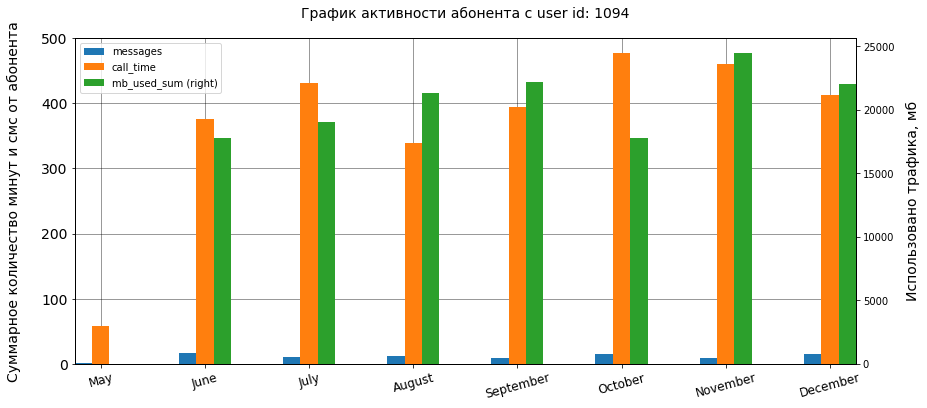

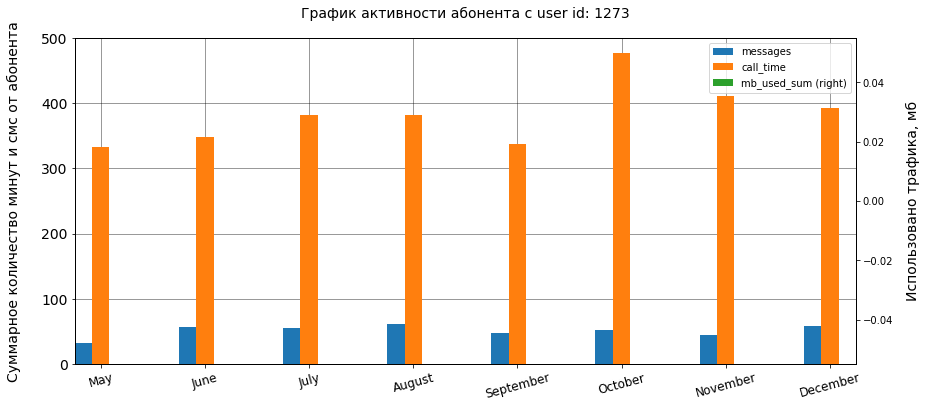

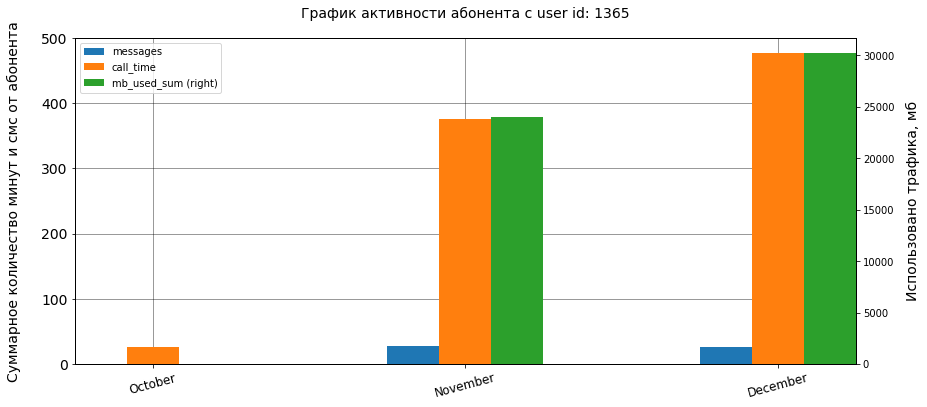

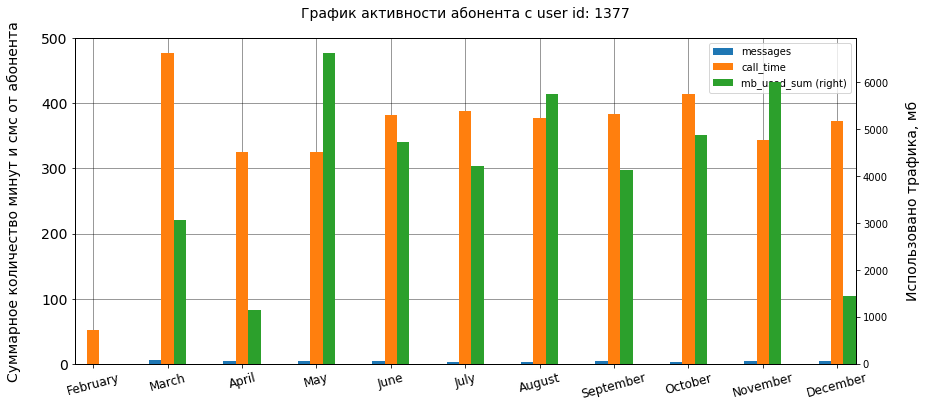

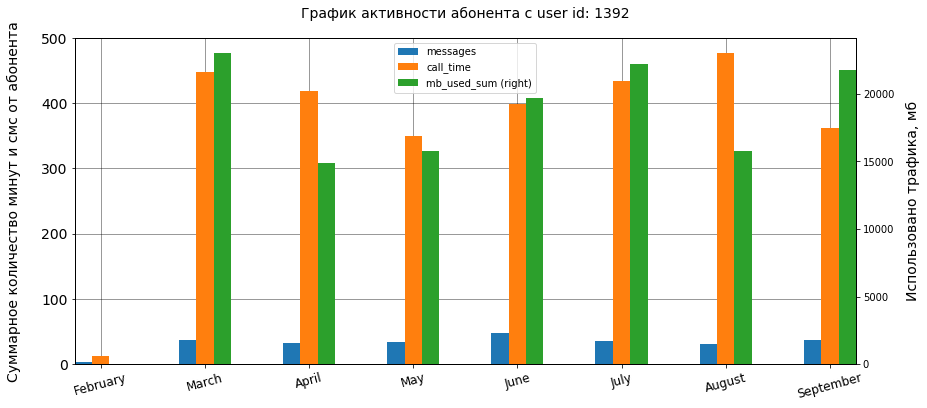

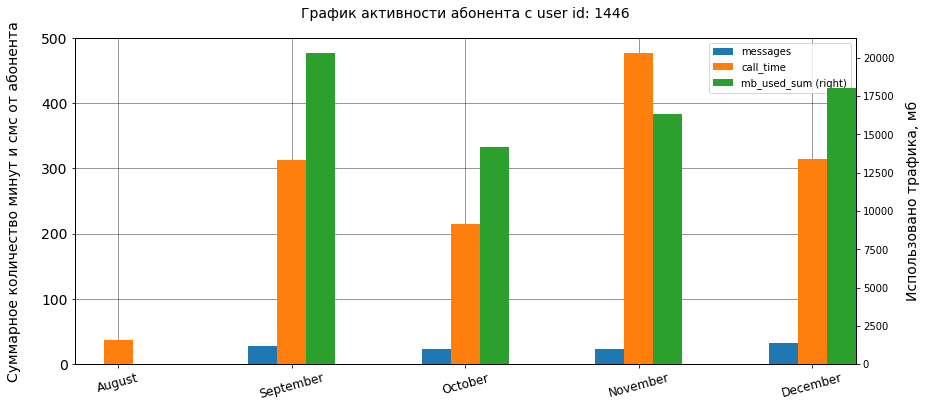

In [28]:
# Start testing
test_tarif = nan_testing(user_com_info, 'tariff_name')
display(test_tarif)

# Get user id of problem places
id_tarif   = test_tarif.index.get_level_values('user_id').unique()

problem_tarif = []
for id_user in id_tarif:
    problem_tarif.append(df_users.loc[df_users['user_id'] == id_user])
    plot4user = vis_user_activiti(user_com_info, id_user, 'messages', 'call_time', 'mb_used_sum')
    
df_problem_tarif = pd.concat(problem_tarif, axis = 0)

#tariff_name
print('Фамилии абонентов со пропущенным тарифом')
display(df_problem_tarif)

#print('Оригинальные данные по интернет трафику')
#display(problem_tarif.head(10))

**Preliminary conclusions:**

From the analysis of the data, we can see that the omissions in the table in the rate field are most likely the result of data merging, which was used earlier to create the table **df_user_internet**. As a result of the merge, empty cells were formed for subscribers who did not use the Internet in certain months, while making calls or sms. Such cases in particular are shown in the bar graphs above. Unfortunately, I was only able to find this answer after carefully analysing the data. To fill in the gaps in this column I use the original subscriber table, where each user has an assigned tariff plan.

By comparing tables **test_tarif** and **df_problem_tarif** you can determine which plan each user had at the time the raw data was received. All that remains is to replace the data.

In [29]:
ultra_users = df_problem_tarif['user_id'].loc[df_problem_tarif.loc[:,'tariff'] == 'ultra'].values
smart_users = df_problem_tarif['user_id'].loc[df_problem_tarif.loc[:,'tariff'] == 'smart'].values

print(ultra_users)
print(smart_users)

[1094 1273 1377 1392]
[1365 1446]


User rates identified, you can start replacing passes

In [30]:
for id_user in ultra_users:
    user_com_info.loc[id_user, "tariff_name"] = "ULTRA"
    
for id_user in smart_users:
    user_com_info.loc[id_user, "tariff_name"] = "SMART"
    

Now the only thing left to do before starting the calculation is to change the case in the **tariff_name** column in order to have a common data format with the table where the tariff plans are presented.

In [31]:
user_com_info['tariff_name'] =  user_com_info['tariff_name'].str.lower()
user_com_info

call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1000    5.0          22.0      159.0      22.0    564.000000       2256.0   
        6.0          43.0      172.0      60.0    528.568182      23257.0   
        7.0          47.0      340.0      75.0    500.571429      14016.0   
        8.0          52.0      408.0      81.0    521.111111      14070.0   
        9.0          58.0      466.0      57.0    583.240000      14581.0   
...                   ...        ...       ...           ...          ...   
1498    10.0         41.0      247.0      42.0    420.489796      20604.0   
1499    9.0           9.0       70.0      11.0    462.000000       1848.0   
        10.0         68.0      449.0      48.0    414.162791      17809.0   
        11.0         74.0      612.0      59.0    461.128205      17984.0   
        12.0         69.0      492.0      66.0    326.925000      13077.0   

              tariff_name  
user_id month              
1000    5.0         ultra  
        6.0         ultra  
        7.0         ultra  
        8.0         ultra  
        9.0         ultra  
...                   ...  
1498    10.0        smart  
1499    9.0         smart  
        10.0        smart  
        11.0        smart  
        12.0        smart  

[3214 rows x 6 columns]

Check data, again

In [32]:
print(get_info(user_com_info  , 'user_com_info' )) 


 ******************** 

Общая информация для таблицы user_com_info 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5.0) to (1499, 12.0)
Data columns (total 6 columns):
call_count      3214 non-null float64
call_time       3214 non-null float64
messages        3214 non-null float64
mb_used_mean    3214 non-null float64
mb_used_sum     3214 non-null float64
tariff_name     3214 non-null object
dtypes: float64(5), object(1)
memory usage: 344.5+ KB


call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1000    5.0          22.0      159.0      22.0    564.000000       2256.0   
        6.0          43.0      172.0      60.0    528.568182      23257.0   
        7.0          47.0      340.0      75.0    500.571429      14016.0   
        8.0          52.0      408.0      81.0    521.111111      14070.0   
        9.0          58.0      466.0      57.0    583.240000      14581.0   

              tariff_name  
user_id month              
1000    5.0         ultra  
        6.0         ultra  
        7.0         ultra  
        8.0         ultra  
        9.0         ultra


 Количество NaN values для таблицы user_com_info: 
 call_count      0
call_time       0
messages        0
mb_used_mean    0
mb_used_sum     0
tariff_name     0
dtype: int64

 Названия столбцов для таблицы user_com_info: Index(['call_count', 'call_time', 'messages', 'mb_used_mean', 'mb_used_sum',
       'tariff_name'],
      dtype='object')

 ******************** 

None


**Preliminary conclusions:**

The raw data is completely ready for further processing. 

### Calculation of subscriber charges

Для этого в первую очередь сформируем два отдельных датафрейма, в одном сгруппируем данные абонентов с тарифом **smart**, в другом **ultra**. Кроме того, с данными нужно будет сделать преобразования, для которых я создам небольшие функции.
1. Для изменения формата данных;
2. Для расчета звонков, смс и объемов интернет трафика больше лимита;
3. Для коррекции отрицательных значений, если абонент не превысил трафик;
4. Для расчета итоговой стоимости с учетом превышений лимитов;


In [33]:
# 1. Function for format corrections
def change_data_format(df):
    col_list = ['call_count', 'call_time'   , 
                'messages'  , 'mb_used_mean', 
                              'mb_used_sum' ]
    for col in col_list:
        if col in ['call_count', 'messages']:
            df[col] = df[col].astype('int64')
        else:
            df[col] = np.ceil(df[col]).astype('int64')
    return df

# 2. Function for calculations of over limits for call, sms and megabytes
def get_limits(df_tarif, df_limit4tarif):
    call_lim = df_tarif['call_time'] - df_limit4tarif['minutes_included']
    sms_lim  = df_tarif['messages']  - df_limit4tarif['messages_included']
    md_lim   = np.ceil((df_tarif['mb_used_sum'] - df_limit4tarif['mb_per_month_included']) / MB2GB).astype('int64')
    return call_lim, sms_lim, md_lim

# 3. Function for corrections negative values in colums with calls, sms and megabytes
def correct_negative_values(df):
    col_list = ['over_calls', 'over_sms', 'over_md']
    
    for row_index in range(len(df)):
        for col in col_list:
            if df[col][row_index] < 0:
                df[col][row_index] = 0
    return df

# 4. Function for calculation income
def company_income(df, df_tarif_cost):
    income = df_tarif_cost['rub_monthly_fee'] + (df['over_calls'] * df_tarif_cost['rub_per_minute'] 
                                               + df['over_sms']   * df_tarif_cost['rub_per_message']
                                               + df['over_md']    * df_tarif_cost['rub_per_gb']    )
    return income

####  Tariff ULTRA

In [34]:
# Get actual data and costs for users with tarif ---> ultra
df_ultra    = user_com_info.loc[user_com_info.loc[:,'tariff_name'] == 'ultra']
tarif_ultra = df_tarrif.loc[1]

#display(df_ultra)
#display(tarif_ultra)

# Change format in dataframes
df_ultra = change_data_format(df_ultra)

# Get new columns for overlimits data
df_ultra['over_calls'], df_ultra['over_sms'], df_ultra['over_md'] = get_limits(df_ultra, tarif_ultra)

# Start negative values corrections 
df_ultra  = correct_negative_values(df_ultra)  

# Start total income calculations
df_ultra['income'] = company_income(df_ultra, tarif_ultra)

# Show new data
df_ultra

call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1000    5.0            22        159        22           564         2256   
        6.0            43        172        60           529        23257   
        7.0            47        340        75           501        14016   
        8.0            52        408        81           522        14070   
        9.0            58        466        57           584        14581   
...                   ...        ...       ...           ...          ...   
1495    8.0            17         92        13           654         2616   
        9.0           112        813        82           495        33105   
        10.0          152       1030        82           516        29393   
        11.0          129        954        79           557        38972   
        12.0          155       1031        84           510        23450   

              tariff_name  over_calls  over_sms  over_md  income  
user_id month                                                     
1000    5.0         ultra           0         0        0    1950  
        6.0         ultra           0         0        0    1950  
        7.0         ultra           0         0        0    1950  
        8.0         ultra           0         0        0    1950  
        9.0         ultra           0         0        0    1950  
...                   ...         ...       ...      ...     ...  
1495    8.0         ultra           0         0        0    1950  
        9.0         ultra           0         0        3    2400  
        10.0        ultra           0         0        0    1950  
        11.0        ultra           0         0        9    3300  
        12.0        ultra           0         0        0    1950  

[985 rows x 10 columns]

#### Tariff  SMART

In [35]:
# Get actual data and costs for users with tarif ---> smart
df_smart    = user_com_info.loc[user_com_info.loc[:,'tariff_name'] == 'smart']
tarif_smart = df_tarrif.loc[0]

#display(df_smart)
display(tarif_smart)

# Change format in dataframes
df_smart = change_data_format(df_smart)

# Get new columns for overlimits data
df_smart['over_calls'], df_smart['over_sms'], df_smart['over_md'] = get_limits(df_smart, tarif_smart)

# Start negative values corrections 
#df_smart  = correct_negative_values(df_smart) 
 
# Start total income calculations
#df_smart['income'] = company_income(df_smart, tarif_smart)

# Show new data
#df_smart

messages_included           50
mb_per_month_included    15360
minutes_included           500
rub_monthly_fee            550
rub_per_gb                 200
rub_per_message              3
rub_per_minute               3
tariff_name              smart
Name: 0, dtype: object

In [36]:
smart_call = df_smart['over_calls'].values
smart_sms  = df_smart['over_sms'].values
smart_md   = df_smart['over_md'].values

def corrections(data):
    for row_index in range(len(data)):
        if data[row_index] < 0:
            data[row_index] = 0
    return data
            
df_smart['over_calls'] = corrections(smart_call)
df_smart['over_sms']   = corrections(smart_sms)
df_smart['over_md']    = corrections(smart_md)

# Start total income calculations
df_smart['income'] = company_income(df_smart, tarif_smart)

df_smart

call_count  call_time  messages  mb_used_mean  mb_used_sum  \
user_id month                                                               
1001    11.0           59        430         0           393        18452   
        12.0           63        414         0           402        14053   
1002    6.0            15        117         4           403        10871   
        7.0            26        214        11           401        17601   
        8.0            42        289        13           407        20347   
...                   ...        ...       ...           ...          ...   
1498    10.0           41        247        42           421        20604   
1499    9.0             9         70        11           462         1848   
        10.0           68        449        48           415        17809   
        11.0           74        612        59           462        17984   
        12.0           69        492        66           327        13077   

              tariff_name  over_calls  over_sms  over_md  income  
user_id month                                                     
1001    11.0        smart           0         0        4    1350  
        12.0        smart           0         0        0     550  
1002    6.0         smart           0         0        0     550  
        7.0         smart           0         0        3    1150  
        8.0         smart           0         0        5    1550  
...                   ...         ...       ...      ...     ...  
1498    10.0        smart           0         0        6    1750  
1499    9.0         smart           0         0        0     550  
        10.0        smart           0         0        3    1150  
        11.0        smart         112         9        3    1513  
        12.0        smart           0        16        0     598  

[2229 rows x 10 columns]

**Preliminary conclusions:**

The two tables showing the monthly profits from each subscriber are done

## Analyzing subscriber activity

In [37]:
users_ultra = df_ultra.reset_index()
users_smart = df_smart.reset_index()

### Tariff ULTRA

In [38]:
df_ultra_com = users_ultra.groupby(['month']).agg({'call_count' : ['count', 'sum', 'mean'],
                                                   'call_time'  : [         'sum', 'mean'],
                                                   'over_calls' : [         'sum'        ],
                                                   'messages'   : [         'sum', 'mean'],
                                                   'over_sms'   : [         'sum'        ],
                                                   'mb_used_sum': [         'sum'        ],
                                                   'over_md'    : [         'sum'        ],
                                                   'income'     : [         'sum'        ]})
# m   - mean
# t   - time
# tol - time_over_limit
# ol  - over limit

# Rename columns
df_ultra_com.columns = ['tot_users'    , 'tot_calls'  , 'm_calls'  ,
                                         'tot_calls_t', 'm_calls_t',
                                         'calls_tol'  ,
                                         'tot_sms'    , 'm_sms'    , 
                                         'sms_ol'     , 
                                         'tot_gb_used', 
                                         'gb_ol'      ,
                                         'tot_income' ]


col_list = ['m_calls', 'm_calls_t', 'm_sms', 'tot_gb_used']
for col in col_list:
    if col == 'tot_gb_used':
        df_ultra_com['tot_gb_used'] = np.ceil(df_ultra_com['tot_gb_used'] / MB2GB).astype('int64')
    else:
        df_ultra_com[col] = np.ceil(df_ultra_com[col]).astype('int64')

df_ultra_com

,tot_users,tot_calls,m_calls,tot_calls_t,m_calls_t,calls_tol,tot_sms,m_sms,sms_ol,tot_gb_used,gb_ol,tot_income
month,,,,,,,,,,,,
1.0,9,535,60,3853,429,0,304,34,0,116,0,17550
2.0,24,997,42,7131,298,0,527,22,0,277,4,47400
3.0,37,2504,68,18117,490,0,1195,33,0,635,16,74550
4.0,55,3525,65,25191,459,0,1736,32,0,905,19,110100
5.0,67,4858,73,34192,511,0,2536,38,0,1269,50,138150
6.0,84,5606,67,40295,480,0,3505,42,0,1554,51,171450
7.0,91,6896,76,49667,546,0,4536,50,0,1824,104,193050
8.0,107,7628,72,54653,511,0,5183,49,0,2048,95,222900
9.0,115,8579,75,62036,540,0,6013,53,0,2159,57,232800


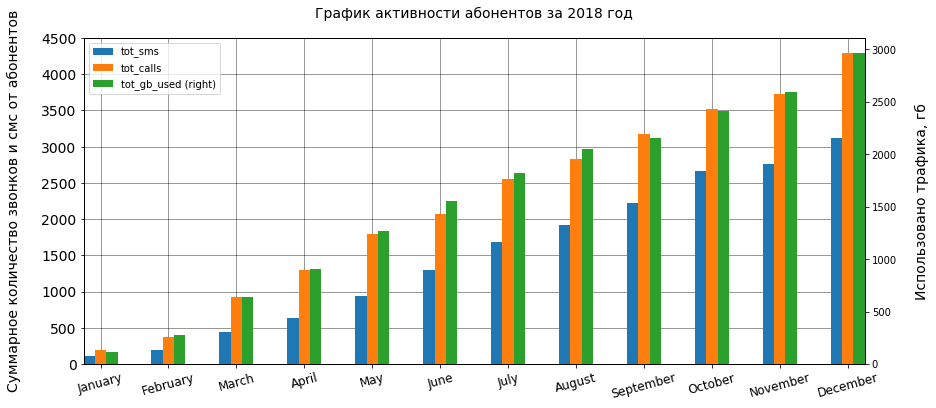

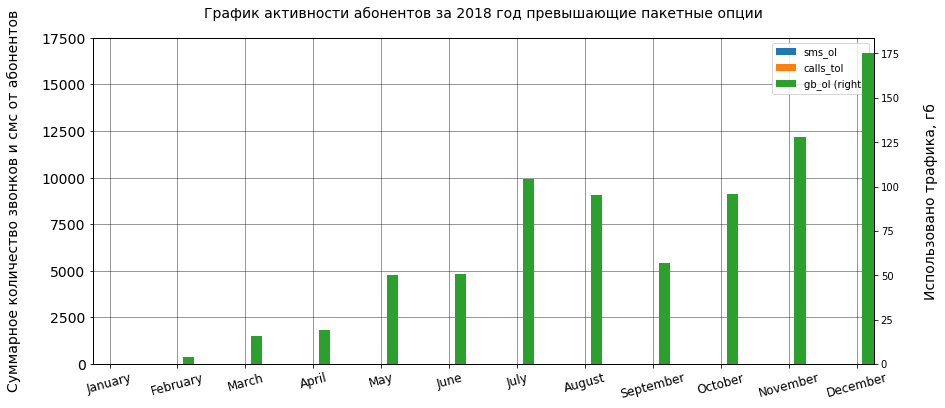

In [39]:
test_plot  = vis_user_activiti(df_ultra_com, None, 'tot_sms'         , 
                                                   'tot_calls'       , 
                                                   'tot_gb_used'     , 
                                                   plot_users = False)


test2_plot = vis_user_activiti(df_ultra_com, None, 'sms_ol'          , 
                                                   'calls_tol'       ,
                                                   'gb_ol'           ,
                                                   plot_users = False, 
                                                   llimit     = True )

'Описательная статистика:'

,user_id,month,call_count,call_time,messages,mb_used_mean,mb_used_sum,over_calls,over_sms,over_md,income
count,985.00,985.00,985.00,985.00,985.00,985.00,985.00,985.0,985.0,985.00,985.00
mean,1263.09,8.25,73.39,526.62,49.36,526.01,19486.90,0.0,0.0,0.81,2071.07
std,140.69,2.87,43.92,317.61,47.80,79.37,10096.32,0.0,0.0,2.53,378.80
min,1000.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1950.00
25%,1143.00,6.00,41.00,284.00,6.00,498.00,11785.00,0.0,0.0,0.00,1950.00
50%,1277.00,9.00,74.00,518.00,38.00,532.00,19324.00,0.0,0.0,0.00,1950.00
75%,1381.00,11.00,104.00,752.00,79.00,566.00,26863.00,0.0,0.0,0.00,1950.00
max,1495.00,12.00,244.00,1673.00,224.00,732.00,49789.00,0.0,0.0,19.00,4800.00


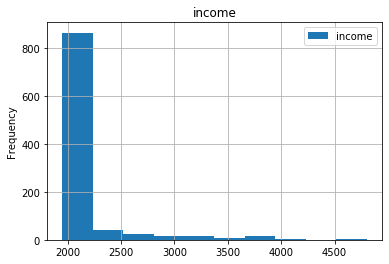

In [40]:
plot1 = histogram(users_ultra, 'income', 10)
stat = users_ultra.describe()
pd.set_option('display.precision', 2)
display(f'Описательная статистика:', stat)

**Conclusions:**

Users of **ULTRA** tariff in most cases per month write from 10 to 80 (on average 40) SMS and use mobile communication to make from 40 to 80 calls, with an average of 490 minutes per month. Highlight of **ULTRA** tariff is active use of Internet for work and communication, users on average use 10 gb to 27 gb of Internet. Some users use up to 50GB of Internet.

Based on the data analysis, we can see that most subscribers of **ULTRA** tariff do not go beyond bundled options, as evidenced by the value of 1950 rubles presented in the summary statistical table, column **income**. The data set of column **income** has a log-normal distribution, skewed to the right (mean = 2070 > median = 1950).

As a result, it can be concluded that **ULTRA** subscribers with a more expensive tariff do not practically go beyond it, thereby avoiding additional costs for the use of the mobile operator's services.

### Tariff SMART

In [41]:
df_smart_com = users_smart.groupby(['month']).agg({'call_count' : ['count', 'sum', 'mean'],
                                                   'call_time'  : [         'sum', 'mean'],
                                                   'over_calls' : [         'sum'        ],
                                                   'messages'   : [         'sum', 'mean'],
                                                   'over_sms'   : [         'sum'        ],
                                                   'mb_used_sum': [         'sum'        ],
                                                   'over_md'    : [         'sum'        ],
                                                   'income'     : [         'sum'        ]})
# m   - mean
# t   - time
# tol - time_over_limit
# ol  - over limit

# Rename columns
df_smart_com.columns = ['tot_users'    , 'tot_calls'  , 'm_calls'  ,
                                         'tot_calls_t', 'm_calls_t',
                                         'calls_tol'  ,
                                         'tot_sms'    , 'm_sms'    , 
                                         'sms_ol'     , 
                                         'tot_gb_used',  
                                         'gb_ol'      ,
                                         'tot_income' ]


col_list = ['m_calls', 'm_calls_t', 'm_sms', 'tot_gb_used']
for col in col_list:
    if col == 'tot_gb_used':
        df_smart_com['tot_gb_used'] = np.ceil(df_smart_com['tot_gb_used'] / MB2GB).astype('int64')
    else:
        df_smart_com[col] = np.ceil(df_smart_com[col]).astype('int64')

df_smart_com

,tot_users,tot_calls,m_calls,tot_calls_t,m_calls_t,calls_tol,tot_sms,m_sms,sms_ol,tot_gb_used,gb_ol,tot_income
month,,,,,,,,,,,,
1.0,34,941,28,6931,204,51,620,19,24,284,28,24525
2.0,58,2331,41,17324,299,860,1397,25,107,658,66,48001
3.0,77,4183,55,30034,391,2656,2453,32,386,1138,191,89676
4.0,112,5747,52,41119,368,3011,3443,31,411,1475,180,107866
5.0,141,7789,56,54618,388,3879,4762,34,754,2180,392,169849
6.0,164,9110,56,64885,396,4823,5478,34,930,2533,454,198259
7.0,201,11402,57,82079,409,6925,6784,34,1163,3095,561,247014
8.0,235,13860,59,99045,422,9560,7905,34,1470,3817,750,312340
9.0,260,15482,60,111439,429,11184,8746,34,1478,4145,727,326386


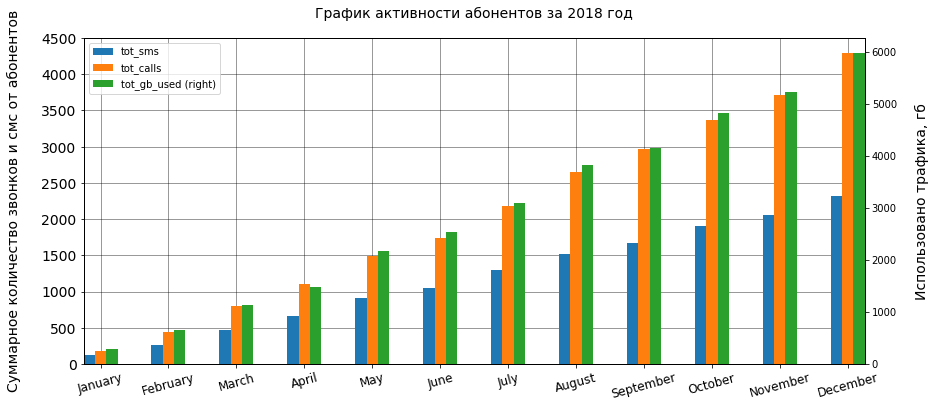

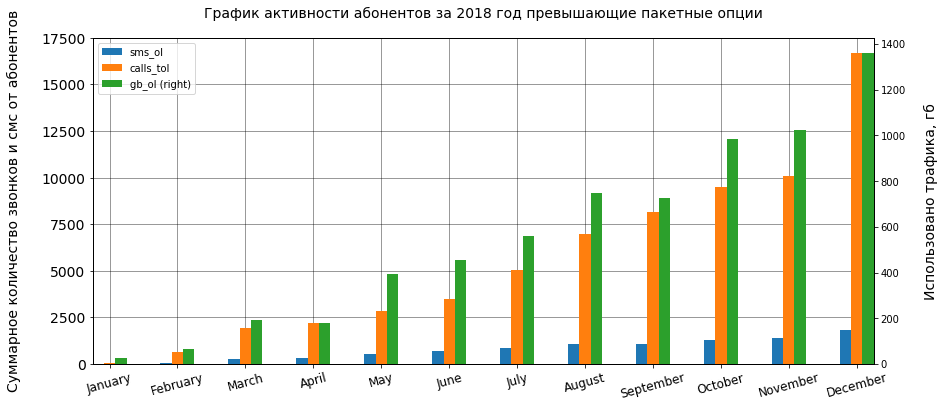

In [42]:
test_plot  = vis_user_activiti(df_smart_com, None, 'tot_sms'         , 
                                                   'tot_calls'       , 
                                                   'tot_gb_used'     , 
                                                   plot_users = False)


test2_plot = vis_user_activiti(df_smart_com, None, 'sms_ol'          , 
                                                   'calls_tol'       ,
                                                   'gb_ol'           ,
                                                   plot_users = False, 
                                                   llimit     = True )

'Описательная статистика: \n'

,user_id,month,call_count,call_time,messages,mb_used_mean,mb_used_sum,over_calls,over_sms,over_md,income
count,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00
mean,1246.51,8.35,58.46,417.93,33.38,386.79,16229.19,41.61,5.80,3.01,1294.64
std,146.12,2.92,25.94,190.31,28.23,44.45,5877.58,84.68,13.44,3.70,820.93
min,1001.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,550.00
25%,1121.00,6.00,40.00,282.00,10.00,362.00,12658.00,0.00,0.00,0.00,550.00
50%,1239.00,9.00,60.00,422.00,28.00,385.00,16531.00,0.00,0.00,2.00,1038.00
75%,1376.00,11.00,76.00,545.00,51.00,411.00,20068.00,45.00,1.00,5.00,1750.00
max,1499.00,12.00,198.00,1435.00,143.00,767.00,38610.00,935.00,93.00,23.00,6770.00


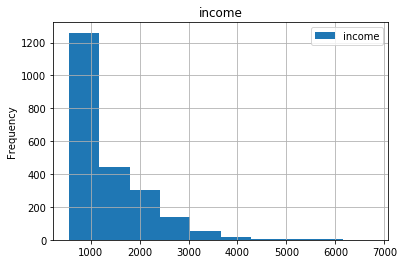

In [43]:
plot1 = histogram(users_smart, 'income', 10)
stat  = users_smart.describe()
pd.set_option('display.precision', 2)
display(f'Описательная статистика: \n', stat)

**Conclusions:**

<font color='blue'>Вывод:</font> Пользователи тарифа **SMART** в большинстве случаев за месяц пишут от 10 до 50 (в среднем 30) смс, и пользуются мобильной связью для совершения от 40 до 80 звонков, со средней продолжительностью 400 минут в месяц. Интернет абоненты тарифа **SMART** в среднем используют от 12 гб до 20 гб интернета, некоторые пользователи используют до 40 гб интернета. Отличительной чертой тарифа **SMART** является то, что абонетны активно пользуются всеми предоставляемыми услугами тарифа, причем в большинстве случаев, как минимум по одному из оценочных показателей выходя за рамки пакетных услуг. Набор данных столбца **income** имеет лог. нормальное распределение, скошенное вправо (mean = 1246 > median = 1239).

На основании проведенного анализа данных видно, что большинство абонентов тарифа **SMART** имея более низкую абоненскую плату (550 рублей) практически каждый месяц доплачивают за использование  дополнительных услуг примерно такую же стоимость, как и за использования тарифа.

### Estimating the company's profits from tariffs

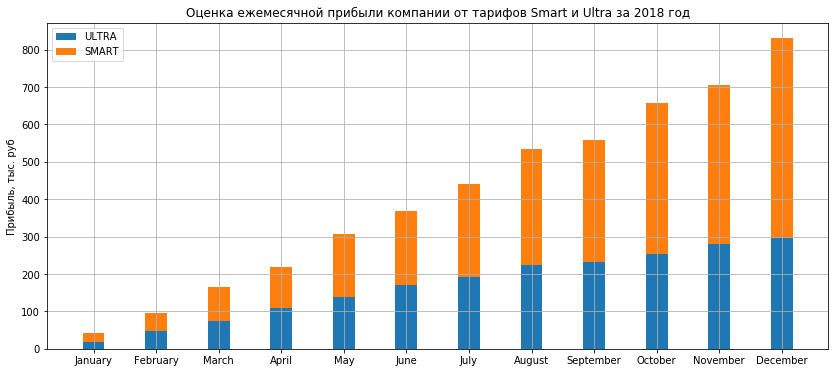

In [44]:
# Get visualizatiom    
fig, ax = plt.subplots(figsize = (14, 6))

tr_ultra = df_ultra_com['tot_income'].values / 1000
tr_smart = df_smart_com['tot_income'].values / 1000
                     
ind      = df_ultra_com.index  #np.arange(N)

width = 0.35

p1 = plt.bar(ind, tr_ultra, width)
p2 = plt.bar(ind, tr_smart, width, bottom = tr_ultra)


plt.title('Оценка ежемесячной прибыли компании от тарифов Smart и Ultra за 2018 год')
plt.ylabel('Прибыль, тыс. руб')             
             
# Get month labels for our user
month_labels = []
for mon in df_ultra_com.index:
    month_labels.append(calendar.month_name[int(mon)])

# Plot data
   
# Set labels for x axis
#N = 12
x_values = np.arange(1, len(month_labels) + 1, 1)
plt.xticks(x_values, month_labels)             
plt.legend((p1[0], p2[0]), ('ULTRA', 'SMART'))

plt.grid(True)

plt.show()

**Conclusions:**

Estimation of the total company profit from the two tariffs demonstrate:

1. The mobile company has a good advertising policy for attracting additional customers, as evidenced by several indicators (growth in the number of subscribers, growth in the total number of sms, calls and internet usage), which has a significant impact on the company's profit, as evidenced by the monthly values in the column with the company's profit.

2. **ULTRA** tariff users pay a higher monthly subscription fee with virtually no additional bundled options to make extra calls and sms, and pay extra money only for extra gigabytes. Not bringing the company any additional benefit. 

3. **SMART** tariff users pay a lower monthly fee, while a rare subscriber manages to stay within the limits of services provided under the existing tariff plan. On average, **SMART** subscribers pay an additional 400-450 roubles for using services that exceed package limits, thereby generating additional revenue for the company. 

4. The monthly revenue graph shows that the company's profits from the **SMART** tariff are higher than those from the **ULTRA** tariff. In addition, the graph also shows that new users mainly choose the **SMART** tariff, as evidenced by the sharper increase in profits for this tariff, while the **ULTRA** tariff is chosen by a relatively small percentage of new subscribers, as evidenced by the very small increase in profits since July.

## Hypothesis testing

### The average revenue of Ultra and Smart tariff users differs:

Исчерпывающей характеристикой любой случайной величины является ее функция распределения (интегральная или дифференциальная). Но основные свойства СВ (хотя и не все) могут быть описаны более компактно с помощью нескольких числовых характеристик (параметров распределения). Поэтому найдем наиболее важную числовую характеристику - центр распределения. 

Существует, по крайней мере, три параметра, характеризующих положение центра распределения (или короче - три характеристики положения): мода, медиана и математическое ожидание, но моду, пока не будем считать. 

математическое ожидание выборки = среднему выборки


In [45]:
# известно, что датасет — не вся совокупность, а выборка из неё
def statistic(df, name):
    data     = df['income'].values
    
    dmean    = np.mean(data)
    dmeadian = np.median(data)
    dstd     = np.std(data, ddof = 1)
    dvar     = np.var(data, ddof = 1)
    
    print(f'Statistic parameters for {name}')
    print(f'Mean  : {dmean:.1f}'   )
    print(f'Median: {dmeadian:.1f}')
    print(f'STD   : {dstd:.1f}'    )
    print(f'VAR   : {dvar:.0f}'    )
    return data

# Get statistical information
ultra_statistic = statistic(users_ultra, 'user ULTRA tarif')
smart_statistic = statistic(users_smart, 'user SMART tarif')

Statistic parameters for user ULTRA tarif
Mean  : 2071.1
Median: 1950.0
STD   : 378.8
VAR   : 143491
Statistic parameters for user SMART tarif
Mean  : 1294.6
Median: 1038.0
STD   : 820.9
VAR   : 673931


Сформулируем статистическую гипотезу. Принимаю **нулевую гипотезу** $H_{0}$, что $m_{x_{\ SMART}} = 2070$, принимаю алтернативную гипотезу, что $m_{x_{\ SMART}} \neq 1950$

Для проверки гипотезы использую использую специальный тест - критерий Стьюдента (t-критерий), который базируется на использовании статистики Стьюдента. В частности нам нужно проверить гипотезу о равенстве средних двух выборок. 

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, примените `метод` scipy.stats.ttest_ind (array1, array2, equal_var).

In [46]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(ultra_statistic, smart_statistic)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


**Conclusions:**

The hypothesis of equality of the mean of the two samples at a significance level of 2a = 10% is rejected and hence the assumption that the average revenue of Ultra and Smart users is different is correct

### The average revenue of users from Moscow differs from users from other regions:

Для того, чтобы ответить на данный вопрос нужно сделать несколько предварительных шагов:
1. Добавить в таблицы users_ultra и users_smart информацию о местоположении абонента.
2. Создать новые датафреймы для пользователей из Москвы и остальных городов России
3. Посчитать статистику

#### Tariff ULTRA

In [47]:
# Get city for all users with ULTRA 
df_ultra_city = df_users.query('tariff == "ultra"')

# Add city to users
df_users_ultra = (users_ultra
                    .merge(df_ultra_city, on = 'user_id', how = 'outer')              # Merge 
                    .drop(['churn_date', 'age'     , 'first_name',                    # Drop columns 
                           'last_name' , 'reg_date', 'tariff'    ], axis = 1)           #  
                    .dropna(thresh = 11)                                              # Drop line with NaN
                    .reset_index(drop = True)                                         # Reset index
                 )


display(df_users_ultra)
display(df_users_ultra.isnull().sum())

,user_id,month,call_count,call_time,messages,mb_used_mean,mb_used_sum,tariff_name,over_calls,over_sms,over_md,income,city
0,1000,5.0,22.0,159.0,22.0,564.0,2256.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
1,1000,6.0,43.0,172.0,60.0,529.0,23257.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
2,1000,7.0,47.0,340.0,75.0,501.0,14016.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
3,1000,8.0,52.0,408.0,81.0,522.0,14070.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
4,1000,9.0,58.0,466.0,57.0,584.0,14581.0,ultra,0.0,0.0,0.0,1950.0,Краснодар
...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,1495,8.0,17.0,92.0,13.0,654.0,2616.0,ultra,0.0,0.0,0.0,1950.0,Иркутск
981,1495,9.0,112.0,813.0,82.0,495.0,33105.0,ultra,0.0,0.0,3.0,2400.0,Иркутск
982,1495,10.0,152.0,1030.0,82.0,516.0,29393.0,ultra,0.0,0.0,0.0,1950.0,Иркутск
983,1495,11.0,129.0,954.0,79.0,557.0,38972.0,ultra,0.0,0.0,9.0,3300.0,Иркутск


user_id         0
month           0
call_count      0
call_time       0
messages        0
mb_used_mean    0
mb_used_sum     0
tariff_name     0
over_calls      0
over_sms        0
over_md         0
income          0
city            0
dtype: int64

In [48]:
# Get new dataframes
df_ultra_moscow = df_users_ultra.query('city == "Москва"')
df_ultra_other  = df_users_ultra.query('city != "Москва"')

# Get statistic
ultra_statistic_moscow = statistic(df_ultra_moscow, 'Users ULTRA Moscow')
ultra_statistic_other  = statistic(df_ultra_other , 'Users ULTRA Other')

Statistic parameters for Users ULTRA Moscow
Mean  : 2075.3
Median: 1950.0
STD   : 353.1
VAR   : 124646
Statistic parameters for Users ULTRA Other
Mean  : 2069.8
Median: 1950.0
STD   : 386.3
VAR   : 149235


Выполним проверку гипотезы: Принимаю, что для Москвы **нулевая гипотеза** $H_{0}$, $m_{x_{\ ULTRA}} = 2069$, принимаю **алтернативную гипотезу** $H_{1}$, что $m_{x_{\ ULTRA}} \neq 2069$

Для проверки гипотезы использую использую специальный тест - критерий Стьюдента (t-критерий), который базируется на использовании статистики Стьюдента. В частности нам нужно проверить гипотезу о равенстве средних двух выборок. 

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, примените `метод` scipy.stats.ttest_ind (array1, array2, equal_var).

In [49]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(ultra_statistic_moscow, ultra_statistic_other)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.8475623384854951
Не получилось отвергнуть нулевую гипотезу


**Conclusions:**

The hypothesis of equality of the mean of the two samples at a significance level of 2a = 10% is not rejected and hence the assumption that the average revenue of **ULTRA** tariff users from Moscow differs from that of **ULTRA** tariff users from other regions is not correct.

#### Tariff SMART

In [50]:
# Get city for all users with SMART 
df_smart_city = df_users.query('tariff == "smart"')

# Add city to users
df_users_smart = (users_smart
                    .merge(df_smart_city, on = 'user_id', how = 'outer')              # Merge 
                    .drop(['churn_date', 'age'     , 'first_name',                    # Drop columns 
                           'last_name' , 'reg_date', 'tariff'    ], axis = 1)           #  
                    .dropna(thresh = 11)                                              # Drop line with NaN
                    .reset_index(drop = True)                                         # Reset index
                 )


display(df_users_smart)
display(df_users_smart.isnull().sum())

,user_id,month,call_count,call_time,messages,mb_used_mean,mb_used_sum,tariff_name,over_calls,over_sms,over_md,income,city
0,1001,11.0,59.0,430.0,0.0,393.0,18452.0,smart,0.0,0.0,4.0,1350.0,Москва
1,1001,12.0,63.0,414.0,0.0,402.0,14053.0,smart,0.0,0.0,0.0,550.0,Москва
2,1002,6.0,15.0,117.0,4.0,403.0,10871.0,smart,0.0,0.0,0.0,550.0,Стерлитамак
3,1002,7.0,26.0,214.0,11.0,401.0,17601.0,smart,0.0,0.0,3.0,1150.0,Стерлитамак
4,1002,8.0,42.0,289.0,13.0,407.0,20347.0,smart,0.0,0.0,5.0,1550.0,Стерлитамак
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224,1498,10.0,41.0,247.0,42.0,421.0,20604.0,smart,0.0,0.0,6.0,1750.0,Владикавказ
2225,1499,9.0,9.0,70.0,11.0,462.0,1848.0,smart,0.0,0.0,0.0,550.0,Пермь
2226,1499,10.0,68.0,449.0,48.0,415.0,17809.0,smart,0.0,0.0,3.0,1150.0,Пермь
2227,1499,11.0,74.0,612.0,59.0,462.0,17984.0,smart,112.0,9.0,3.0,1513.0,Пермь


user_id         0
month           0
call_count      0
call_time       0
messages        0
mb_used_mean    0
mb_used_sum     0
tariff_name     0
over_calls      0
over_sms        0
over_md         0
income          0
city            0
dtype: int64

In [51]:
# Get new dataframes
df_smart_moscow = df_users_smart.query('city == "Москва"')
df_smart_other  = df_users_smart.query('city != "Москва"')

# Get statistic
smart_statistic_moscow = statistic(df_smart_moscow, 'Users SMART Moscow')
smart_statistic_other  = statistic(df_smart_other , 'Users SMART Other' )

Statistic parameters for Users SMART Moscow
Mean  : 1245.1
Median: 1011.5
STD   : 755.0
VAR   : 570033
Statistic parameters for Users SMART Other
Mean  : 1305.0
Median: 1040.0
STD   : 833.9
VAR   : 695390


Выполним проверку гипотезы: Принимаю, что для Москвы **нулевая гипотеза** $H_{0}$, $m_{x_{\ SMART}} = 1268$, принимаю **алтернативную гипотезу** $H_{1}$, что $m_{x_{\ SMART}} \neq 1268$

In [52]:
alpha = 0.05  # critical level of statistical significance
# if the p-value is less than it - reject the hypothesis

results = st.ttest_ind(smart_statistic_moscow, smart_statistic_other)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis') 

p-значение: 0.19196326570657848
Не получилось отвергнуть нулевую гипотезу


**Conclusions:**

The hypothesis of equality of the mean of the two samples at a significance level of 2a = 10% is not rejected and hence the assumption that the average revenue of **SMART** tariff users from Moscow differs from **SMART** tariff users from other regions is not correct.

#### Additional comment

The original hypothesis in the assignment was that there was no need to split smart and ultra users into two additional subcategories for Moscow and other cities, but I realized this fact only after I had calculated everything. But based on the data we can argue that since: the hypothesis of equality of the average of the two samples at a significance level of 2a = 10% is not refuted for both tariffs, hence the assumption that the average revenue of users from Moscow is different from users from other regions is not true.

## General conclusion

In the course of the work, data for 2018 were obtained and analysed for **SMART** and **ULTRA** tariff users. Based on the data obtained, it was found that the **SMART** tariff, brings the company more profit (almost twice as much - as of December 2018) than the **ULTRA** tariff. In addition, it was found that there is no significant difference in the company's average profit margin for Moscow and other Russian regions.

Recommendations: A more detailed analysis of the **ULTRA** tariff is needed to draw additional attention to this tariff, in particular to reduce the subscription fee. 